# Machine Learning
## Titanic Data

This notebook works through Python machine learning using [scikit-learn](http://scikit-learn.org/).

This code and much of the explanation is from [this blog post](http://blog.socialcops.com/engineering/machine-learning-python).

The Titanic passenger manifest data is from [here](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls).

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import cross_validation, tree, preprocessing
import sklearn.ensemble as ske

The new libraries to import are from [scikit-learn](http://scikit-learn.org/stable/).

From `sklearn` we'll be using the following modules:

- `cross_validation` allows us to split our data into training and test sets, so that we can test our trained model against unseen data to avoid overfitting
- `tree` allows us to create a decision tree to be used for classification
- `preprocessing` contains a bunch of utility functions to convert your raw data into a representation of your data that is more suitable for working with inside the various machine learning algorithms

We can use the `sklearn.ensemble` module to combine the results of several estimators to improve the results we would achive by using just one estimator.

To get started, import the Titanic data from the Excel document provided.  The Pandas `read_excel` function works just like `read_csv`, but because an Excel document can contain multiple sheets, we also need to specify which sheet to import.

In [55]:
titanic_df = pd.read_excel('titanic3.xls', 'titanic3', index_col=None, na_values=['NA'])
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


The columns in the DataFrame contain the following information:

- **`pclass`** is the Passenger ticket class.  1 = First, 2 = Second and 3 = Third
- **`survived`** is an indicator of whether the passenger survived or not.  1 means that they survived and 0 they did not.
- **`name`** is the passenger name
- **`sex`** the sex of the passenger, male or female
- **`age`** age of the passnger
- **`sibsp`** is the number of siblings or spouses aboard
- **`parch`** is the number of parents or children aboard
- **`ticket`** is the passengers ticket number
- **`fare`** is the passenger cabin fare
- **`cabin`** is the cabin number for the passenger
- **`embarked`** is the port where this passenger embarked.  C = Cherbourg, Q = Queenstown and S = Shouthampton.
- **`boat`** is the lifeboat number (for those passengers that survived)
- **`body`** is the body number for the passenger, if they did not survive and the body was recovered
- **`home.dest`** is the passengers home and destination

> More detail about the Titanic 3 dataset can be [found here](http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf).

As you can see there is a lot of missing data, but already we can work out things like the average survival rate on the Titanic:

In [56]:
titanic_df.survived.mean()

0.3819709702062643

Let's start by cleaning up the data we have.  A quick inspection of the DataFrame with the `count` method will give us a bit of an idea of which columns are complete, and which are not:

In [57]:
titanic_df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

The first thing to do is to drop columns that won't be relevant.  Whether we found the body or not, what cabin they were in, which boat they took and what their home/destination was are all missing a lot of data so while they may be relevant (for example, cabin distance from a lifeboat might be a factor), the missing data will throw off our calculations.  To drop them us the `drop` method:

In [58]:
titanic_df = titanic_df.drop(['body','cabin','boat', 'home.dest'], axis=1)
titanic_df.count()

pclass      1309
survived    1309
name        1309
sex         1309
age         1046
sibsp       1309
parch       1309
ticket      1309
fare        1308
embarked    1307
dtype: int64

Then, let's drop any rows that have missing data:

In [59]:
titanic_df = titanic_df.dropna()
titanic_df.count()

pclass      1043
survived    1043
name        1043
sex         1043
age         1043
sibsp       1043
parch       1043
ticket      1043
fare        1043
embarked    1043
dtype: int64

As you can see, we're down to 1043 records from the original 1309, but we have complete data for all the columns.  Now we can digging in to the data.  Let's see how different ticket classes impacted on passenger survival rate:

In [60]:
titanic_df.groupby('pclass').mean()

,survived,age,sibsp,parch,fare
pclass,,,,,
1,0.634752,39.083038,0.478723,0.414894,92.316091
2,0.440613,29.506705,0.417625,0.390805,21.855044
3,0.262000,24.745000,0.564000,0.442000,12.879299


Clearly being in First class gave you a better chance of survival.  We can go futher and look at how different genders fared in each of the passenger classes:

In [61]:
class_sex_grouping = titanic_df.groupby(['pclass','sex']).mean()
class_sex_grouping

survived        age     sibsp     parch        fare
pclass sex                                                        
1      female  0.961832  36.839695  0.564885  0.511450  112.485402
       male    0.350993  41.029250  0.403974  0.331126   74.818213
2      female  0.893204  27.499191  0.514563  0.669903   23.267395
       male    0.145570  30.815401  0.354430  0.208861   20.934335
3      female  0.473684  22.185307  0.736842  0.796053   14.655758
       male    0.169540  25.863027  0.488506  0.287356   12.103374

As you can see, women were much more likely to survive than men - "women and children first".

To have a look at the survival rate by age, we're going to do two things:  First we're going to organise the ages of the passengers into bins, and then graph the average survival rate of the passengers in each of the bins. 

First, let's create our bins - we'll want to lump passengers together within 10 year windows, so 0 to 10, 10 to 20, 20 to 30 etc.  To do this we need to create an array of those values - we could type them out, but Numpy has a function to do that; `arange`:

In [62]:
np.arange(0, 90, 10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80])

Starting from 0, stopping before 90, in steps of 10 - gives us the array we need.  Now we can feed that into the Pandas `cut` function.  The `cut` function will look at each of the elements we pass it and decide which of the bins it fits in to.  So we want to bin the `age` column, and sort the ages into the bin of 10 year windows from 0 through to 80:

In [63]:
group_by_age = pd.cut(titanic_df["age"], np.arange(0, 90, 10))

Let's have a quick look at the age values in our dataset:

In [64]:
titanic_df['age'].head()

0    29.0000
1     0.9167
2     2.0000
3    30.0000
4    25.0000
Name: age, dtype: float64

and also what the `cut` function has done:

In [65]:
group_by_age.head()

0    (20, 30]
1     (0, 10]
2     (0, 10]
3    (20, 30]
4    (20, 30]
Name: age, dtype: category
Categories (8, object): [(0, 10] < (10, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 80]]

As you can see, the age of the first passenger is 29, so `cut` has put that in the bin that ranges from 20 to 30.  The third passenger was 2 years old, and is in the bin that ranges from 0 to 10.

Now the last thing to do is to get the averages of our columns by grouping on our new binned data and returning the mean:

In [66]:
age_grouping = titanic_df.groupby(group_by_age).mean()
age_grouping.head()

,pclass,survived,age,sibsp,parch,fare
age,,,,,,
"(0, 10]",2.651163,0.581395,4.304264,1.709302,1.406977,29.436044
"(10, 20]",2.524691,0.395062,17.283951,0.611111,0.395062,28.807050
"(20, 30]",2.371191,0.371191,25.324100,0.326870,0.218837,28.159013
"(30, 40]",2.114833,0.421053,35.107656,0.363636,0.416268,42.523045
"(40, 50]",1.787879,0.393939,45.367424,0.378788,0.409091,47.254231


So let's plot the survival rate:

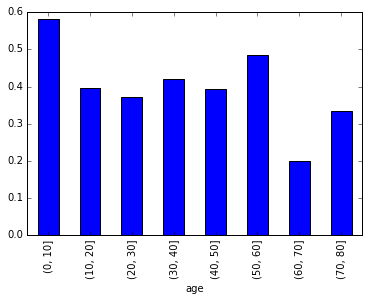

In [67]:
age_grouping['survived'].plot.bar()

OK, now that we've got a feel for the data and cleaned it up, let's move on to the machine learning part and see if we can use the data to make some predictions.  Let's just have a quick look at the data that we have again:

In [68]:
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,S


Computer work better with numerical data than with text, so before we can begin training and testing, we need to clean up the text data and transform it into numerical values.  We could just select some arbitrary values (female = 1, male = 0) but this won't be terribly useful if we have a lot of data to work with.  This is where the `preprocessing` module come in.  It looks at the values you have in a column, generates labels for your data and updates it to use the new numerical values.  Before we jump in with the Titanic data, let's look at a toy example.  We need the `preprocessing` module from `sklearn`, but we already imported it, so I'm just repeating it (commented out) as a reminder.  Then, let's create some toy data - we'll work with a list of values.

In [69]:
# from sklearn import preprocessing
toy_data = ['Apple', 'Orange', 'Apple', 'Banana', 'Banana', 'Apple', 'Orange']

Then, create a new `LabelEncoder`:

In [74]:
toy_le = preprocessing.LabelEncoder()

The first part of the process is to "fit" the data:

In [75]:
toy_le.fit(toy_data)

LabelEncoder()

You can see what `fit` has done by inspecting the internal property of the LabelEncoder object called `classes_`.  As you can see, it's worked out the unique values from our list.

In [76]:
list(toy_le.classes_)

['Apple', 'Banana', 'Orange']

Here we have a list where index 0 is Apple, index 1 is Banana and index 2 is Orange. 

Now let's transform our `toy_data` and see what happens:

In [77]:
toy_le.transform(toy_data)

array([0, 2, 0, 1, 1, 0, 2])

If you look back to the original data, the first element was `Apple` which has now been transformed to `0`, which corresponds to index 0 of the list we generated with the `fit` function.  Similarly, the second element was `Orange` that has been transformed to `2` that corresponds to index 2 in our list from the `fit` function.

Now let's apply those same steps to our titanic data.  First, create the LabelEncoder:

In [78]:
le = preprocessing.LabelEncoder()

Now, make a copy of the original data and apply the `fit` and `transform` methods of the LabelEncoder to `sex` and `embarked` columns of the DataFrame:

In [84]:
processed_df = titanic_df.copy()
processed_df.sex = le.fit_transform(processed_df.sex)
processed_df.embarked = le.fit_transform(processed_df.embarked)

In machine learning we want to work with categorical data, which `sex` and `embark` are.  Name and ticket number are not categorical (each one is unique) so they won't be valuable in our machine learning algorithm and we can drop them. Let's do that and have a look what we're got:

In [85]:
processed_df = processed_df.drop(['name','ticket'],axis=1)
processed_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,0,29.0000,0,0,211.3375,2
1,1,1,1,0.9167,1,2,151.5500,2
2,1,0,0,2.0000,1,2,151.5500,2
3,1,0,1,30.0000,1,2,151.5500,2
4,1,0,0,25.0000,1,2,151.5500,2


Now we need to separate our data into two parts, typicall called `X` and `y`.  `X` will be all of our data _except_ the column we want to train to predict, and `y` the values we have.  So in this case we will take the `survived` column and store that in `y` and then store the rest of the columns in `X`:

In [87]:
X = processed_df.drop(['survived'], axis=1).values
y = processed_df['survived'].values

When we train the algorithm it will look for patterns in each of the rows in `X` that result in the corresponding value in `y`.  To do the actual training we need to split the data into training and testing data.  This let's us use the training data to come up with the model and then test that model on the test data - because we are testing on data that wasn't used in training, we wont be overfitting.  The `cross_validation` module of `sklearn` has a function `train_test_split` that returns test and train sets for our `X` and `y` data.  You pass in the `X` and `y` data sets along with a ratio of how much data you want to use as the test - in this case we're going to train with 80% of the data and test with the remaining 20%:"

In [88]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

Now we can begin training using the training data sets (`X_train` and `y_train`) and testing the result with the test data (`X_test` and `y_test`).  scikit-learn has a number of different classifiers, let's start with a Decision Tree Classifier:

In [89]:
clf_dt = tree.DecisionTreeClassifier(max_depth=10)

Now you can train (using the `fit` function) the data to the classifier using the training data, and test it's accuracy using the `score` function:

In [90]:
clf_dt.fit(X_train, y_train)
clf_dt.score(X_test, y_test)

0.8133971291866029

Let's test a couple of others as well - a Random Forest Classifier and a Gradient Boosting Classifier:

In [92]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf.fit(X_train, y_train)
clf_rf.score(X_test, y_test)

0.80382775119617222

In [93]:
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
clf_gb.fit(X_train, y_train)
clf_gb.score(X_test, y_test)

0.84688995215311003

We can also pass all three of our classifiers in to a Voting Classifier that will return the best results from all of the classifiers:

In [94]:
eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
eclf.fit(X_train, y_train)
eclf.score(X_test, y_test)

0.84688995215311003

Lastly, let's create a completely new passenger and predict whether they would have survived or not.  Remember that our `X` data was a grid of rows and columns, so we need to create a list of lists with our data:

In [105]:
new_passenger = [[2, 0, 40, 0, 0, 200, 1]]
eclf.predict(new_passenger)

array([1])

Our model reckons that a 40 year old female passenger with a second class ticket would have survived.